<a href="https://colab.research.google.com/github/MalikBabaar/Riped-and-Unriped-Tomato/blob/main/Riped%20and%20Unriped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [36]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [37]:
# Set dataset paths
base_dir = '/content/drive/MyDrive/Riped and Unriped Tomato Dataset'  # CHANGE THIS
images_dir = os.path.join(base_dir, 'Images')
labels_dir = os.path.join(base_dir, 'labels')

In [38]:
def parse_yolo_label(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    # We'll use the first class ID (first number in first line) as our label
    if len(lines) > 0:
        return int(lines[0].split()[0])  # First number is the class
    return 0  # Default to unripe if no label

In [39]:
# Get all image files and corresponding labels
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
labels = []

In [40]:
for img_file in image_files:
    label_file = os.path.join(labels_dir, os.path.splitext(img_file)[0] + '.txt')
    label = parse_yolo_label(label_file)
    labels.append(label)

# Create DataFrame
df = pd.DataFrame({'filename': image_files, 'label': labels})
print("Label distribution:")
print(df['label'].value_counts())

Label distribution:
label
1    91
0    86
Name: count, dtype: int64


In [41]:
# Split into train and validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print("\nTrain samples:", len(train_df))
print("Validation samples:", len(val_df))


Train samples: 141
Validation samples: 36


In [42]:
# Data generator
def dataframe_generator(df, batch_size, img_size=(128, 128), augment=False):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    ) if augment else ImageDataGenerator(rescale=1./255)

    while True:
        batch = df.sample(n=batch_size)
        images = []
        labels = []
        for _, row in batch.iterrows():
            img_path = os.path.join(images_dir, row['filename'])
            img = load_img(img_path, target_size=img_size)
            img = img_to_array(img)
            img = datagen.random_transform(img) if augment else img
            img = datagen.standardize(img)
            images.append(img)
            labels.append(row['label'])
        yield np.array(images), np.array(labels)

In [43]:
# Parameters
img_width, img_height = 128, 128
batch_size = 32

# Create generators
train_gen = dataframe_generator(train_df, batch_size, (img_width, img_height), augment=True)
val_gen = dataframe_generator(val_df, batch_size, (img_width, img_height))

# Calculate steps
steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size

In [44]:
# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [46]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/best_model.h5', monitor='val_loss', save_best_only=True)

In [47]:
# Training
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=30,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.5306 - loss: 0.6841 - precision: 0.5468 - recall: 0.5515

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5354 - loss: 0.6808 - precision: 0.5514 - recall: 0.5736 - val_accuracy: 0.5312 - val_loss: 0.6497 - val_precision: 0.5161 - val_recall: 1.0000
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7331 - loss: 0.6161 - precision: 0.7186 - recall: 0.7520

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7333 - loss: 0.6131 - precision: 0.7309 - recall: 0.7274 - val_accuracy: 0.7188 - val_loss: 0.6092 - val_precision: 1.0000 - val_recall: 0.4375
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7591 - loss: 0.5607 - precision: 0.8007 - recall: 0.6995   

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7573 - loss: 0.5600 - precision: 0.7868 - recall: 0.7151 - val_accuracy: 0.6875 - val_loss: 0.5352 - val_precision: 0.6250 - val_recall: 0.9375
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.8841 - loss: 0.4239 - precision: 0.8669 - recall: 0.9324

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8885 - loss: 0.4175 - precision: 0.8743 - recall: 0.9318 - val_accuracy: 0.7812 - val_loss: 0.4567 - val_precision: 0.7368 - val_recall: 0.8750
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.8913 - loss: 0.3483 - precision: 0.9247 - recall: 0.8458

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 856ms/step - accuracy: 0.8865 - loss: 0.3484 - precision: 0.9259 - recall: 0.8378 - val_accuracy: 0.7812 - val_loss: 0.4075 - val_precision: 0.7368 - val_recall: 0.8750
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9030 - loss: 0.2809 - precision: 0.9402 - recall: 0.8698

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9052 - loss: 0.2807 - precision: 0.9374 - recall: 0.8785 - val_accuracy: 0.7812 - val_loss: 0.3909 - val_precision: 0.7368 - val_recall: 0.8750
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9401 - loss: 0.2284 - precision: 0.9468 - recall: 0.9348

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9333 - loss: 0.2378 - precision: 0.9471 - recall: 0.9197 - val_accuracy: 0.8438 - val_loss: 0.3530 - val_precision: 0.8235 - val_recall: 0.8750
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9354 - loss: 0.2036 - precision: 0.9562 - recall: 0.9275 - val_accuracy: 0.7812 - val_loss: 0.5029 - val_precision: 0.6957 - val_recall: 1.0000
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8938 - loss: 0.2529 - precision: 0.8417 - recall: 0.9275 - val_accuracy: 0.7812 - val_loss: 0.3810 - val_precision: 0.7368 - val_recall: 0.8750
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9000 - loss: 0.2775 - precision: 0.9138 - recall: 0.8350 - val_accuracy: 0.8438 - val_loss: 0.3719 - val_precision: 0.8235 - val_recall: 0.8750
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9104 - loss: 0.2299 - precision: 0.9500 - recall: 0.8625 - val_accuracy: 0.8438 - val_loss: 0.4890 - val_precision: 0.7619 - val

In [50]:
# Evaluation
model = tf.keras.models.load_model('/content/best_model.h5')

# Evaluation - Create non-shuffling generator
eval_gen = dataframe_generator(val_df.copy(), batch_size, (img_width, img_height), augment=False)
y_true = val_df['label'].values[:validation_steps * batch_size]  # Align with generator output
y_pred = model.predict(eval_gen, steps=validation_steps)
y_pred = (y_pred > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


In [51]:
# Metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['unripe', 'ripe']))


Classification Report:
              precision    recall  f1-score   support

      unripe       0.42      0.29      0.34        17
        ripe       0.40      0.53      0.46        15

    accuracy                           0.41        32
   macro avg       0.41      0.41      0.40        32
weighted avg       0.41      0.41      0.40        32



In [52]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Confusion Matrix:
[[ 5 12]
 [ 7  8]]


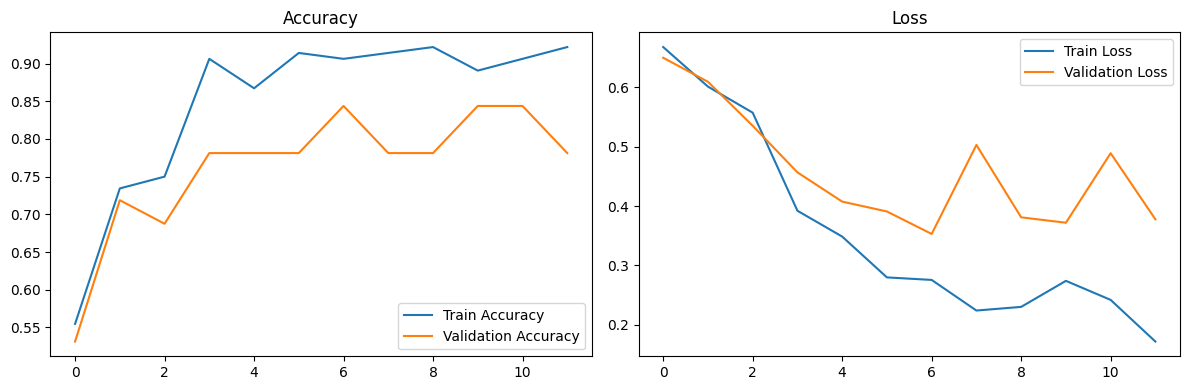

In [54]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [55]:
# Save model
!cp '/content/best_model.h5' '/content/drive/MyDrive/'
print("Model saved to Google Drive!")

Model saved to Google Drive!
